In [20]:
import nltk.stem
import string
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer, PorterStemmer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [21]:
mainDf = pd.read_csv("justice.csv")
mainDf = mainDf.drop(['Unnamed: 0', 'ID', 'name', 'href', 'docket', 'term', 'first_party',
       'second_party', 'facts_len', 'majority_vote', 'minority_vote', 'decision_type', 'disposition'], axis=1)

In [22]:
mainDf["issue_area"].isna().sum()


142

In [23]:
mainDf = mainDf.dropna(axis=0)

In [24]:
len(mainDf)

3159

In [25]:
mainDf = mainDf.reset_index(drop=True)

In [48]:
mainDf.head()

,facts,first_party_winner,issue_area,new_issue_area,lemma,lemmaPos
0,"[joan, stanley, three, children, peter, stanle...",True,Civil Rights,Civil Rights,"[joan, stanley, three, child, peter, stanley, ...","[(joan, NN), (stanley, VBD), (three, CD), (chi..."
1,"[john, giglio, convicted, passing, forged, mon...",True,Due Process,Others,"[john, giglio, convicted, passing, forged, mon...","[(john, NN), (giglio, NN), (convicted, VBD), (..."
2,"[idaho, probate, code, specified, males, must,...",True,Civil Rights,Civil Rights,"[idaho, probate, code, specified, male, prefer...","[(idaho, JJ), (probate, NN), (code, NN), (spec..."
3,"[miller, conducting, mass, mailing, campaign, ...",True,First Amendment,First Amendment,"[miller, conducting, mass, mailing, campaign, ...","[(miller, NN), (conducting, VBG), (mass, NN), ..."
4,"[ernest, mandel, belgian, professional, journa...",True,First Amendment,First Amendment,"[ernest, mandel, belgian, professional, journa...","[(ernest, JJS), (mandel, NN), (belgian, JJ), (..."


In [74]:
mainDf["first_party_winner"] = mainDf['first_party_winner'].replace({"True": 1, "False": 0})

# Analysis of the data

Before starting changing anything on the dataset, we check the number of data for each prediction outcome.

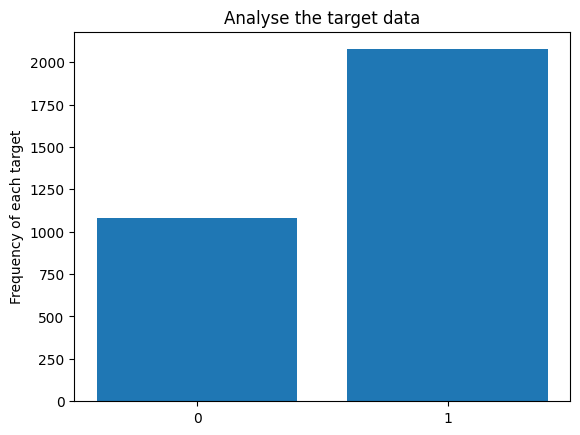

In [ ]:
freqTarget = mainDf.groupby(["first_party_winner"], as_index=False, sort=True)["facts"].count()
plt.bar(freqTarget["first_party_winner"], freqTarget["facts"])
plt.xticks(freqTarget["first_party_winner"])
plt.title("Analyse the target data")
plt.ylabel('Frequency of each target')
plt.show()

Also the issue area is important to analyse to see if we can combine some categories. We noticed a very large difference in number between each issue_area category, hence we decided to combine the small categories into "Others". Now we can see that the categories for the issue areas have very close numbers of people.

In [28]:
mainDf["new_issue_area"] = mainDf['issue_area'].replace({"Due Process": "Others", "Privacy": "Others", "Federal Taxation": "Others", 
                                                     "Unions": "Others", "Federalism": "Others", "Attorneys": "Others",
                                                     "Miscellaneous": "Others", "Interstate Relations": "Others", "Private Action": "Others"})

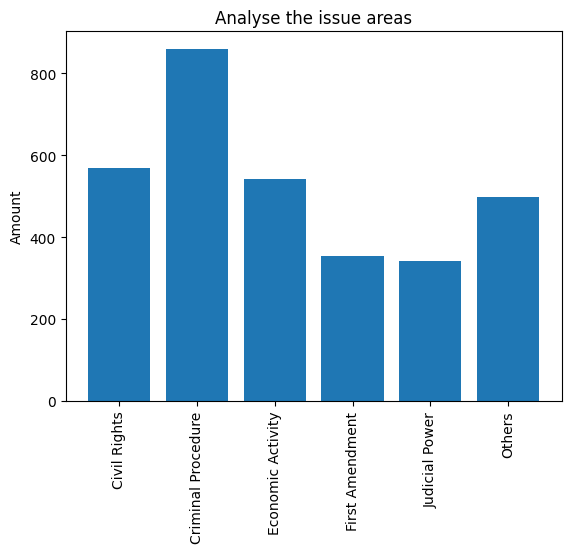

In [29]:
freqTarget = mainDf.groupby(["new_issue_area"], as_index=False, sort=True)["facts"].count()

plt.bar(freqTarget["new_issue_area"], freqTarget["facts"])
plt.xticks(freqTarget["new_issue_area"])
plt.title("Analyse the issue areas")
plt.xticks(rotation=90)
plt.ylabel('Amount')
plt.show()

# Cleaning the data

We are ready now to clean the facts column from our data. First, we will split the string and then delete numbers, spaces, symbols and word of 1 character. After that, we can tokennize the word for each row. As we also know, stopwords are useless for a machine to understand the context of the text. Hence we will delete those.

In [30]:
documents = []
X = mainDf["facts"]
pattern = r'[' + string.punctuation + ']'

for i in range(0, len(X)):
  document = sample_str = re.sub(pattern, " ", str(X[i]))
  document = re.sub(r"\W", " ", document)
  document = re.sub(r"\d+", " ", document)
  document = re.sub(r'\b\w{1,1}\b', " ", document)
  document = re.sub(" \d+", " ", document)
  document = re.sub(r"\s+", " ", document, flags=re.I)
  document = document.lower()
  documents.append(document)

In [31]:
tokenDocuments = []
for i in range(0, len(X)):
    tokenDocuments.append(word_tokenize(documents[i]))

In [32]:
stop_words = stopwords.words("english")

In [33]:
cleanTokenDocuments = []

for i in range(0, len(X)):
    cleanTokenDocument = []
    for word in tokenDocuments[i]:
        if word not in stop_words:
            cleanTokenDocument.append(word)
    cleanTokenDocuments.append(cleanTokenDocument)
mainDf["facts"] = cleanTokenDocuments

We can lemmatize and do a Postag on the remaining words. We will save it in the same dataframe.

In [34]:
lemma = WordNetLemmatizer()

mainDf["lemma"] = mainDf["facts"].apply(lambda x: [lemma.lemmatize(y) for y in x])

In [35]:
postagDocuments = []
for sen in mainDf["lemma"]:
    postagDocuments.append(pos_tag(sen))

mainDf["lemmaPos"] = postagDocuments

Putting every word that we have until now in a corpus, this corpus contain almost 19k unique words. We decided to delete even more words that we think of not being important for context. After putting the remaining words in a corpus, we have suddenly almostt 17k unique words.

In [36]:
words_set = set()
 
for doc in mainDf["facts"]:
    for word in doc:
        if word not in words_set:
            words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 18561


In [37]:
lemmaWithSomePostagDocuments = []
for sen in mainDf["lemmaPos"]:
    lemmaWithSomePostagDocument = []
    for w in sen:
        if w[1] != "UH" and w[1] != "WP" and w[1] != "WP$" and w[1] != "WRB" and w[1] != "PRP" and w[1] != "PRP$" and w[1] != "MD" and w[1] != "WDT":
            lemmaWithSomePostagDocument.append(w[0])
    lemmaWithSomePostagDocuments.append(lemmaWithSomePostagDocument)
            
mainDf["lemma"] = lemmaWithSomePostagDocuments

In [38]:
words_set = set()
 
for doc in mainDf["lemma"]:
    for word in doc:
        if word not in words_set:
            words_set.add(word)
     
print('Number of words in the corpus:',len(words_set))

Number of words in the corpus: 16648


## Analysis of the words

The following code will help us find the most 15 frequent words. We then plot those frequency numbers.

In [76]:
words = []
freqOfWords = []

for doc in mainDf["lemma"]:
    for word in doc:
        if word not in words:
            words.append(word)
            freqOfWords.append(1)
        else:
            idx = words.index(word)
            freqOfWords[idx] = freqOfWords[idx] + 1

In [77]:
d = {'words': words, 'frequency': freqOfWords}
freqWordDf = pd.DataFrame(data=d)
freqWordDf = freqWordDf.sort_values(by=['frequency'])

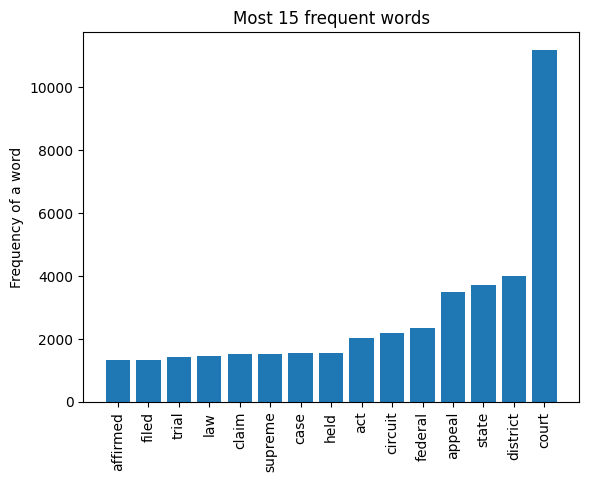

In [78]:
plt.bar(freqWordDf.tail(15)["words"], freqWordDf.tail(15)["frequency"])
plt.xticks(freqWordDf.tail(15)["words"])
plt.title("Most 15 frequent words")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

It is also interesting to see the most frequent words for those cases which were won by the first party and the most frequent words for those case which were lost by the first party.

In [79]:
words = []
targetVar = []
onesList = []
for row in range(0, len(mainDf["lemma"])):
    for word in mainDf["lemma"][row]:
        words.append(word)
        targetVar.append(mainDf["first_party_winner"][row]) 
        onesList.append(1)

In [80]:
d = {'words': words, 'first_party_winner': targetVar, "listOfOnes": onesList}
freqDf = pd.DataFrame(data=d)

In [81]:
countFreqDf = freqDf.groupby(["first_party_winner", "words"], as_index=False, sort=True)["listOfOnes"].count()

In [82]:
countFreqDfZeros = countFreqDf[countFreqDf['first_party_winner'].isin([0])].sort_values(by=['listOfOnes'])
countFreqDfZeros[countFreqDfZeros["listOfOnes"].isin([1])].count()

first_party_winner    3324
words                 3324
listOfOnes            3324
dtype: int64

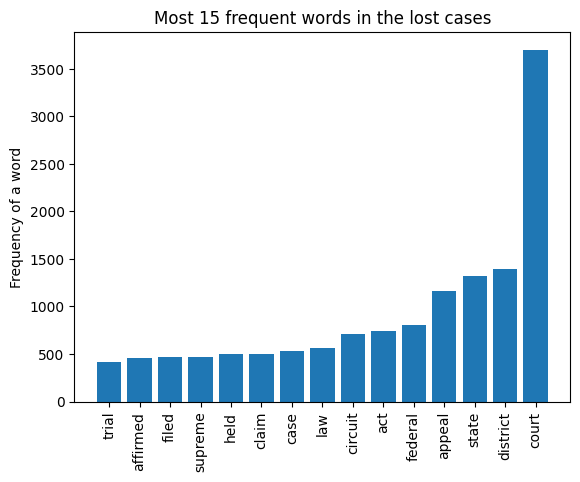

In [240]:
plt.bar(countFreqDfZeros.tail(15)["words"], countFreqDfZeros.tail(15)["listOfOnes"])
plt.xticks(countFreqDfZeros.tail(15)["words"])
plt.title("Most 15 frequent words in the lost cases")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

In [241]:
countFreqDfOnes = countFreqDf[countFreqDf['first_party_winner'].isin([1])].sort_values(by=['listOfOnes'])
countFreqDfOnes[countFreqDfOnes["listOfOnes"].isin([1])].count()

first_party_winner    4302
words                 4302
listOfOnes            4302
dtype: int64

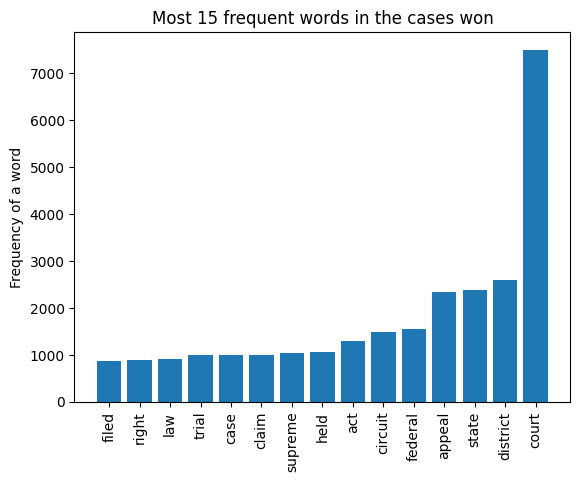

In [242]:
plt.bar(countFreqDfOnes.tail(15)["words"], countFreqDfOnes.tail(15)["listOfOnes"])
plt.xticks(countFreqDfOnes.tail(15)["words"])
plt.title("Most 15 frequent words in the cases won")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

# Second dataset

## Cleaning the second dataset

We are going to do exactly the same steps to clean the dataset as we did for the justice dataset.

In [39]:
secondDf = pd.read_csv("us_classactions_verdicts.csv")

In [40]:
secondDf.head()

,id,target_text,verdict
0,99002,Knowing and/or Willful Violation of the Telep...,lose
1,138068,17. Defendants operate an electrical construc...,win
2,319755,(Fair Labor Standards Act Violations) (Viola...,win
3,155208,"37. As set forth below, the proposed Class sa...",win
4,390338,24. Named Plaintiffs and Class Members were em...,win


In [ ]:
len(secondDf)

In [57]:
secondDf.rename(columns = {'target_text':'facts', 'verdict': "first_party_winner"}, inplace = True)

In [42]:
documents = []
X = secondDf["facts"]
pattern = r'[' + string.punctuation + ']'

for i in range(0, len(X)):
  document = sample_str = re.sub(pattern, " ", str(X[i]))
  document = re.sub(r"\W", " ", document)
  document = re.sub(r"\d+", " ", document)
  document = re.sub(r'\b\w{1,1}\b', " ", document)
  document = re.sub(" \d+", " ", document)
  document = re.sub(r"\s+", " ", document, flags=re.I)
  document = document.lower()
  documents.append(document)

In [43]:
tokenDocuments = []
for i in range(0, len(X)):
    tokenDocuments.append(word_tokenize(documents[i]))

In [44]:
cleanTokenDocuments = []

for i in range(0, len(X)):
    cleanTokenDocument = []
    for word in tokenDocuments[i]:
        if word not in stop_words:
            cleanTokenDocument.append(word)
    cleanTokenDocuments.append(cleanTokenDocument)
secondDf["facts"] = cleanTokenDocuments

In [45]:
secondDf["lemma"] = secondDf["facts"].apply(lambda x: [lemma.lemmatize(y) for y in x])

In [46]:
postagDocuments = []
for sen in secondDf["lemma"]:
    postagDocuments.append(pos_tag(sen))

secondDf["lemmaPos"] = postagDocuments

In [49]:
lemmaWithSomePostagDocuments = []
for sen in secondDf["lemmaPos"]:
    lemmaWithSomePostagDocument = []
    for w in sen:
        if w[1] != "UH" and w[1] != "WP" and w[1] != "WP$" and w[1] != "WRB" and w[1] != "PRP" and w[1] != "PRP$" and w[1] != "MD" and w[1] != "WDT":
            lemmaWithSomePostagDocument.append(w[0])
    lemmaWithSomePostagDocuments.append(lemmaWithSomePostagDocument)
            
secondDf["lemma"] = lemmaWithSomePostagDocuments

In [50]:
words_set_of_secondDf = set()
 
for doc in secondDf["lemma"]:
    for word in doc:
        if word not in words_set_of_secondDf:
            words_set_of_secondDf.add(word)
     
print('Number of words in the corpus:',len(words_set_of_secondDf))

Number of words in the corpus: 26342


We can see many more words in this second dataset then the previous one, hence we will need to delete all of those extra words.

In [53]:
words_in_secondDf_not_in_mainDf = []
for word in words_set_of_secondDf:
    if word not in words_set:
        words_in_secondDf_not_in_mainDf.append(word)

In [58]:
lemmaWithTooManyWordsDocuments = []
for sen in secondDf["lemma"]:
    lemmaWithTooManyWordsDocument = []
    for w in sen:
        if w in words_set:
            lemmaWithTooManyWordsDocument.append(w)
    lemmaWithTooManyWordsDocuments.append(lemmaWithTooManyWordsDocument)
            
secondDf["lemmaWithDeletedWords"] = lemmaWithTooManyWordsDocuments

In [59]:
secondDf.head()

,id,facts,first_party_winner,lemma,lemmaPos,lemmaWithDeletedWords
0,99002,"[knowing, willful, violation, telephone, consu...",lose,"[knowing, willful, violation, telephone, consu...","[(knowing, VBG), (willful, JJ), (violation, NN...","[knowing, willful, violation, telephone, consu..."
1,138068,"[defendants, operate, electrical, construction...",win,"[defendant, operate, electrical, construction,...","[(defendant, NN), (operate, JJ), (electrical, ...","[defendant, operate, electrical, construction,..."
2,319755,"[fair, labor, standards, act, violations, viol...",win,"[fair, labor, standard, act, violation, violat...","[(fair, JJ), (labor, NN), (standard, NN), (act...","[fair, labor, standard, act, violation, violat..."
3,155208,"[set, forth, proposed, class, satisfies, requi...",win,"[set, forth, proposed, class, satisfies, requi...","[(set, VBN), (forth, NNS), (proposed, VBD), (c...","[set, forth, proposed, class, satisfies, requi..."
4,390338,"[named, plaintiffs, class, members, employed, ...",win,"[named, plaintiff, class, member, employed, de...","[(named, VBN), (plaintiff, JJ), (class, NN), (...","[named, plaintiff, class, member, employed, de..."


## Analysis of the second dataset

In [85]:
secondDf["first_party_winner"] = secondDf['first_party_winner'].replace({"lose": 0, "win": 1})

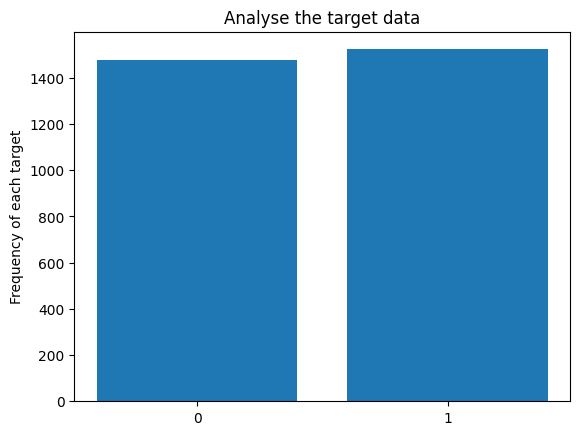

In [86]:
freqTarget = secondDf.groupby(["first_party_winner"], as_index=False, sort=True)["facts"].count()
plt.bar(freqTarget["first_party_winner"], freqTarget["facts"])
plt.xticks(freqTarget["first_party_winner"])
plt.title("Analyse the target data")
plt.ylabel('Frequency of each target')
plt.show()

In [87]:
words = []
freqOfWords = []

for doc in secondDf["lemma"]:
    for word in doc:
        if word not in words:
            words.append(word)
            freqOfWords.append(1)
        else:
            idx = words.index(word)
            freqOfWords[idx] = freqOfWords[idx] + 1

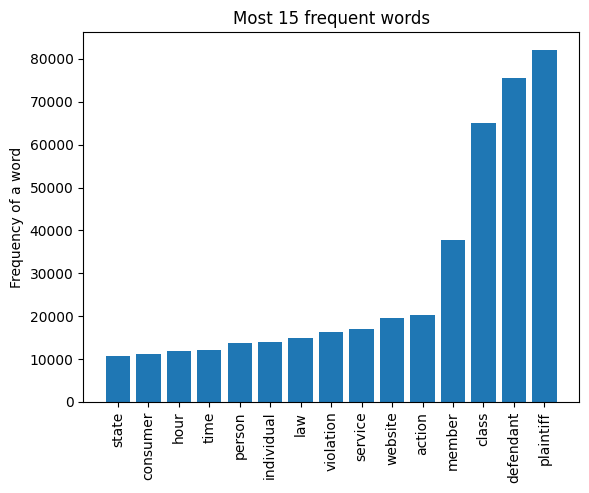

In [88]:
d = {'words': words, 'frequency': freqOfWords}
freqWordDf = pd.DataFrame(data=d)
freqWordDf = freqWordDf.sort_values(by=['frequency'])

plt.bar(freqWordDf.tail(15)["words"], freqWordDf.tail(15)["frequency"])
plt.xticks(freqWordDf.tail(15)["words"])
plt.title("Most 15 frequent words")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

In [89]:
words = []
freqOfWords = []

for doc in secondDf["lemmaWithDeletedWords"]:
    for word in doc:
        if word not in words:
            words.append(word)
            freqOfWords.append(1)
        else:
            idx = words.index(word)
            freqOfWords[idx] = freqOfWords[idx] + 1

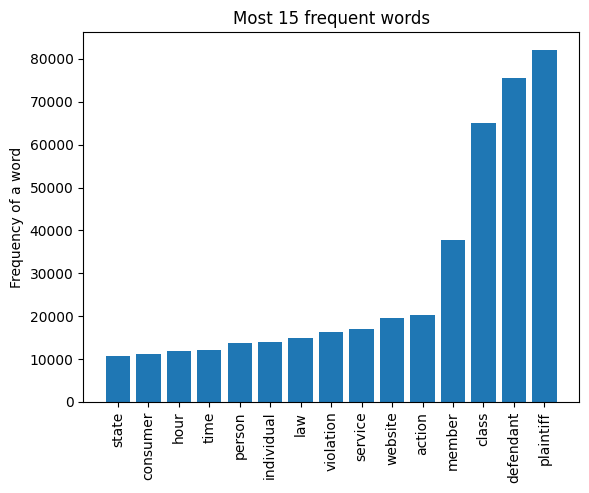

In [90]:
d = {'words': words, 'frequency': freqOfWords}
freqWordDf = pd.DataFrame(data=d)
freqWordDf = freqWordDf.sort_values(by=['frequency'])

plt.bar(freqWordDf.tail(15)["words"], freqWordDf.tail(15)["frequency"])
plt.xticks(freqWordDf.tail(15)["words"])
plt.title("Most 15 frequent words")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

In [68]:
words = []
targetVar = []
onesList = []
for row in range(0, len(secondDf["lemmaWithDeletedWords"])):
    for word in secondDf["lemmaWithDeletedWords"][row]:
        words.append(word)
        targetVar.append(secondDf["first_party_winner"][row]) 
        onesList.append(1)

In [69]:
d = {'words': words, 'first_party_winner': targetVar, "listOfOnes": onesList}
freqDf = pd.DataFrame(data=d)

In [92]:
countFreqDf = freqDf.groupby(["first_party_winner", "words"], as_index=False, sort=True)["listOfOnes"].count()

In [93]:
countFreqDfZeros = countFreqDf[countFreqDf['first_party_winner'].isin([0])].sort_values(by=['listOfOnes'])
countFreqDfZeros[countFreqDfZeros["listOfOnes"].isin([1])].count()

first_party_winner    3324
words                 3324
listOfOnes            3324
dtype: int64

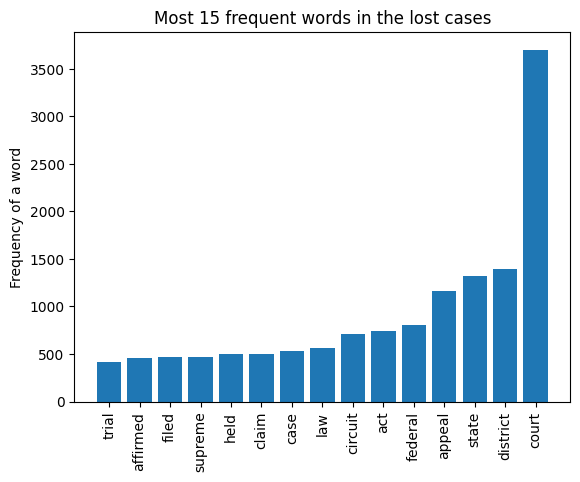

In [94]:
plt.bar(countFreqDfZeros.tail(15)["words"], countFreqDfZeros.tail(15)["listOfOnes"])
plt.xticks(countFreqDfZeros.tail(15)["words"])
plt.title("Most 15 frequent words in the lost cases")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

In [95]:
countFreqDfOnes = countFreqDf[countFreqDf['first_party_winner'].isin([1])].sort_values(by=['listOfOnes'])
countFreqDfOnes[countFreqDfOnes["listOfOnes"].isin([1])].count()

first_party_winner    4302
words                 4302
listOfOnes            4302
dtype: int64

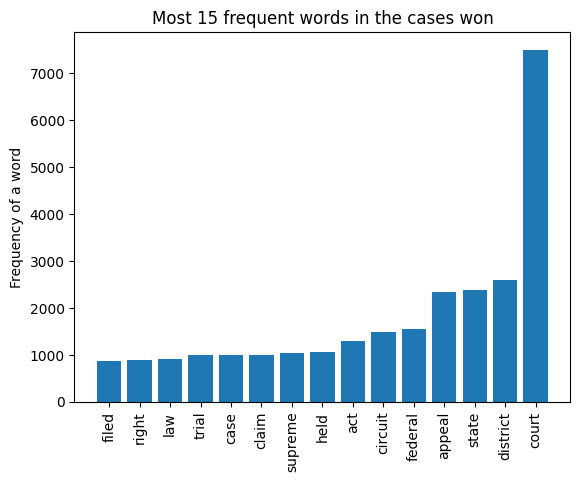

In [96]:
plt.bar(countFreqDfOnes.tail(15)["words"], countFreqDfOnes.tail(15)["listOfOnes"])
plt.xticks(countFreqDfOnes.tail(15)["words"])
plt.title("Most 15 frequent words in the cases won")
plt.ylabel('Frequency of a word')
plt.xticks(rotation = 90) 
plt.show()

# Word2Vec

In [243]:
from gensim.models import Word2Vec

In [244]:
model = Word2Vec(sentences=mainDf["lemma"], vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [245]:
model = Word2Vec.load("word2vec.model")

In [246]:
vecDim = []

for i in range(0, len(mainDf)):
    wordToNumber = []
    for wordToVec in mainDf["lemma"][i]:
        wordToNumber.append(model.wv['court'])
    vecDim.append(wordToNumber)
vecDimDf = pd.DataFrame({"vec": vecDim})

In [247]:
maxLengthOfVec = 0
for i in range(0, len(vecDim)):
    if len(vecDim[i]) > maxLengthOfVec:
        maxLengthOfVec = len(vecDim[i])

In [248]:
maxLengthOfVec

531

In [249]:
mainDf = pd.merge(mainDf, vecDimDf, left_index=True, right_index=True)

In [256]:
mainDf["label_issue_area"] = mainDf['new_issue_area'].replace({'Civil Rights': 1, 'Others': 2, 
                                                                'First Amendment': 3, 'Criminal Procedure': 4,
                                                               'Economic Activity': 5, 'Judicial Power': 6})

In [257]:
mainDf

,facts,first_party_winner,issue_area,new_issue_area,lemma,lemmaPos,vec,vec_mean,label_issue_area
0,"[joan, stanley, three, children, peter, stanle...",True,Civil Rights,Civil Rights,"[joan, stanley, three, child, peter, stanley, ...","[(joan, NN), (stanley, VBD), (three, CD), (chi...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1
1,"[john, giglio, convicted, passing, forged, mon...",True,Due Process,Others,"[john, giglio, convicted, passing, forged, mon...","[(john, NN), (giglio, NN), (convicted, VBD), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",2
2,"[idaho, probate, code, specified, males, must,...",True,Civil Rights,Civil Rights,"[idaho, probate, code, specified, male, prefer...","[(idaho, JJ), (probate, NN), (code, NN), (spec...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1
3,"[miller, conducting, mass, mailing, campaign, ...",True,First Amendment,First Amendment,"[miller, conducting, mass, mailing, campaign, ...","[(miller, NN), (conducting, VBG), (mass, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",3
4,"[ernest, mandel, belgian, professional, journa...",True,First Amendment,First Amendment,"[ernest, mandel, belgian, professional, journa...","[(ernest, JJS), (mandel, NN), (belgian, JJ), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",3
...,...,...,...,...,...,...,...,...,...
3154,"[century, alaska, purchase, federal, governmen...",True,Civil Rights,Civil Rights,"[century, alaska, purchase, federal, governmen...","[(century, NN), (alaska, JJ), (purchase, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1
3155,"[refugio, palomar, santiago, mexican, national...",True,Criminal Procedure,Criminal Procedure,"[refugio, palomar, santiago, mexican, national...","[(refugio, NN), (palomar, NN), (santiago, JJ),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",4
3156,"[tarahrick, terry, pleaded, guilty, one, count...",False,Criminal Procedure,Criminal Procedure,"[tarahrick, terry, pleaded, guilty, one, count...","[(tarahrick, NN), (terry, NN), (pleaded, VBD),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",4
3157,"[joshua, james, cooley, parked, pickup, truck,...",True,Civil Rights,Civil Rights,"[joshua, james, cooley, parked, pickup, truck,...","[(joshua, NN), (james, NNS), (cooley, VBP), (p...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838...","[2.97191162109375, 1.938203125, 1.421348876953...",1


------------------------------------------------------
------------------------------------------------------

DO NOT RUN IT!!

In [196]:
padVec = np.zeros(100)

In [198]:
for i in range(0, len(mainDf)):
    while len(mainDf["vec"][i]) < maxLengthOfVec:
        mainDf["vec"][i].append(padVec)

------------------------------------------------
------------------------------------------------

In [251]:
mainDf

,facts,first_party_winner,issue_area,new_issue_area,lemma,lemmaPos,vec
0,"[joan, stanley, three, children, peter, stanle...",True,Civil Rights,Civil Rights,"[joan, stanley, three, child, peter, stanley, ...","[(joan, NN), (stanley, VBD), (three, CD), (chi...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
1,"[john, giglio, convicted, passing, forged, mon...",True,Due Process,Others,"[john, giglio, convicted, passing, forged, mon...","[(john, NN), (giglio, NN), (convicted, VBD), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
2,"[idaho, probate, code, specified, males, must,...",True,Civil Rights,Civil Rights,"[idaho, probate, code, specified, male, prefer...","[(idaho, JJ), (probate, NN), (code, NN), (spec...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3,"[miller, conducting, mass, mailing, campaign, ...",True,First Amendment,First Amendment,"[miller, conducting, mass, mailing, campaign, ...","[(miller, NN), (conducting, VBG), (mass, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
4,"[ernest, mandel, belgian, professional, journa...",True,First Amendment,First Amendment,"[ernest, mandel, belgian, professional, journa...","[(ernest, JJS), (mandel, NN), (belgian, JJ), (...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
...,...,...,...,...,...,...,...
3154,"[century, alaska, purchase, federal, governmen...",True,Civil Rights,Civil Rights,"[century, alaska, purchase, federal, governmen...","[(century, NN), (alaska, JJ), (purchase, NN), ...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3155,"[refugio, palomar, santiago, mexican, national...",True,Criminal Procedure,Criminal Procedure,"[refugio, palomar, santiago, mexican, national...","[(refugio, NN), (palomar, NN), (santiago, JJ),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3156,"[tarahrick, terry, pleaded, guilty, one, count...",False,Criminal Procedure,Criminal Procedure,"[tarahrick, terry, pleaded, guilty, one, count...","[(tarahrick, NN), (terry, NN), (pleaded, VBD),...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."
3157,"[joshua, james, cooley, parked, pickup, truck,...",True,Civil Rights,Civil Rights,"[joshua, james, cooley, parked, pickup, truck,...","[(joshua, NN), (james, NNS), (cooley, VBP), (p...","[[-0.5843567, 2.279764, 0.53048813, 0.05563838..."


In [252]:
vec_mean_vec = []
for i in range(0, len(mainDf)):
    vec_mean = []
    for j in range(0, len(mainDf["vec"])):
        feature_vec = np.sum(mainDf["vec"][j])
        vec_mean.append(feature_vec/100)
    vec_mean_vec.append(vec_mean)
vecDimDf = pd.DataFrame({"vec_mean": vec_mean_vec})

In [253]:
mainDf = pd.merge(mainDf, vecDimDf, left_index=True, right_index=True)

In [258]:
X = mainDf["vec_mean"]
y = mainDf["label_issue_area"]

In [259]:
X_array = np.array(X)
y_array = np.array(y)

In [260]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [266]:
X_train = np.vstack(X_train)

In [267]:
X_train.shape, y_train.shape

((2527, 3159), (2527,))

In [ ]:
y_train[]

In [268]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train);

In [269]:
result = rf.predict(X_train)

In [273]:
result.shape, y_test.shape

((2527,), (632,))

In [274]:
print(classification_report(y_train, result))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       460
           2       0.00      0.00      0.00       396
           3       0.00      0.00      0.00       282
           4       0.27      1.00      0.43       686
           5       0.00      0.00      0.00       443
           6       0.00      0.00      0.00       260

    accuracy                           0.27      2527
   macro avg       0.05      0.17      0.07      2527
weighted avg       0.07      0.27      0.12      2527



/Users/carolina/Documents/Semester_9/Natural_Language_Processing/SupremeCourtJudgementPrediction/my_envnlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolina/Documents/Semester_9/Natural_Language_Processing/SupremeCourtJudgementPrediction/my_envnlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolina/Documents/Semester_9/Natural_Language_Processing/SupremeCourtJudgementPrediction/my_envnlp/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedM